In [8]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

from pytensor.graph import Apply, Op
from scipy.optimize import approx_fprime

Here, we sampled value of $Y-data$, where $Y$ is the model value and $data$ is the observed value. We then calculated the log-likelihood of the sampled data. We will use this sampled data to interpolate the log-likelihood.

$$loglikelihood = -\frac{(y-data)^2}{2\sigma}-log(\sqrt{2\pi})-log(\sigma)$$

To simplify the problem, we assume that the standard deviation of the noise is known and equal to 1. We also assume that the noise is Gaussian. The likelihood of the data given the model is then given by:

$$p(data|Y) = \frac{1}{\sqrt{2\pi}}exp(-\frac{(Y-data)^2}{2})$$

We adopted a black box likelihood function, which is a function that takes the data and the model parameters as input and returns the log-likelihood, and do not require gradient. (Thus may occur some problem if we extract the gradient of the log-likelihood function)

This example is based on the PyMC3 example [here](https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html).

# Black box likelihood

In [ ]:
sampled_data = np.linspace(-500, 500, 1000)
sampled_log_likelihood = -0.5 * ((sampled_data) / 1) ** 2 - np.log(np.sqrt(2 * np.pi)) - np.log(1)

In [ ]:
def interpolate(x0, y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

In [ ]:
def my_model(m, c, x):
    return m * x + c

def my_loglike(m, c, sigma, x, data):
    # Use interpolation to get the log-likelihood
    for param in (m, c, sigma, x, data):
        if not isinstance(param, (float, np.ndarray)):
            raise TypeError(f"Invalid input type to loglike: {type(param)}")
    model = my_model(m, c, x)
    return interpolate(sampled_data, sampled_log_likelihood, model-data) 

In [ ]:
import numpy as np

N = 10  
sigma = 1.0  
x = np.linspace(0.0, 9.0, N)

mtrue = 0.4 
ctrue = 3.0 

truemodel = my_model(mtrue, ctrue, x)

# make data
rng = np.random.default_rng(716743)
data = sigma * rng.normal(size=N) + truemodel

In [ ]:
class LogLike(Op):
    def make_node(self, m, c, sigma, x, data) -> Apply:
        # Convert inputs to tensor variables
        m = pt.as_tensor(m)
        c = pt.as_tensor(c)
        sigma = pt.as_tensor(sigma)
        x = pt.as_tensor(x)
        data = pt.as_tensor(data)
        inputs = [m, c, sigma, x, data]
        outputs = [data.type()]

        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        m, c, sigma, x, data = inputs  
        loglike_eval = my_loglike(m, c, sigma, x, data)
        outputs[0][0] = np.asarray(loglike_eval)

In [ ]:
loglike_op = LogLike()

test_out = loglike_op(mtrue, ctrue, sigma, x, data)

In [ ]:
pytensor.dprint(test_out, print_type=True)

In [ ]:
test_out.eval()

In [ ]:
def custom_dist_loglike(data, m, c, sigma, x):
    return loglike_op(m, c, sigma, x, data)



with pm.Model() as no_grad_model:
    m = pm.Uniform("m", lower=-10.0, upper=10.0, initval=mtrue)
    c = pm.Uniform("c", lower=-10.0, upper=10.0, initval=ctrue)


    likelihood = pm.CustomDist(
        "likelihood", m, c, sigma, x, observed=data, logp=custom_dist_loglike
    )
    

In [ ]:
with no_grad_model:
    idata_no_grad = pm.sample(3000, tune=1000)

In [ ]:
az.summary(idata_no_grad)

In [ ]:
az.plot_trace(idata_no_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

# With gradients

In [ ]:
def finite_differences_loglike(m, c, sigma, x, data, eps=1e-7):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using scipy approx_fprime function.

    Parameters
    ----------
    m, c: array_like
        The parameters of the function for which we wish to define partial derivatives
    x, data, sigma:
        Observed variables as we have been using so far


    Returns
    -------
    grad_wrt_m: array_like
        Partial derivative wrt to the m parameter
    grad_wrt_c: array_like
        Partial derivative wrt to the c parameter
    """

    def inner_func(mc, sigma, x, data):
        return my_loglike(*mc, sigma, x, data)

    grad_wrt_mc = approx_fprime([m, c], inner_func, [eps, eps], sigma, x, data)

    return grad_wrt_mc[:, 0], grad_wrt_mc[:, 1]

In [ ]:
class LogLikeWithGrad(Op):
    def make_node(self, m, c, sigma, x, data) -> Apply:
        # Same as before
        m = pt.as_tensor(m)
        c = pt.as_tensor(c)
        sigma = pt.as_tensor(sigma)
        x = pt.as_tensor(x)
        data = pt.as_tensor(data)

        inputs = [m, c, sigma, x, data]
        outputs = [data.type()]
        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        # Same as before
        m, c, sigma, x, data = inputs  # this will contain my variables
        loglike_eval = my_loglike(m, c, sigma, x, data)
        outputs[0][0] = np.asarray(loglike_eval)

    def grad(
        self, inputs: list[pt.TensorVariable], g: list[pt.TensorVariable]
    ) -> list[pt.TensorVariable]:
        # NEW!
        # the method that calculates the gradients - it actually returns the vector-Jacobian product
        m, c, sigma, x, data = inputs

        # Our gradient expression assumes these are scalar parameters
        if m.type.ndim != 0 or c.type.ndim != 0:
            raise NotImplementedError("Gradient only implemented for scalar m and c")

        grad_wrt_m, grad_wrt_c = loglikegrad_op(m, c, sigma, x, data)

        # out_grad is a tensor of gradients of the Op outputs wrt to the function cost
        [out_grad] = g
        return [
            pt.sum(out_grad * grad_wrt_m),
            pt.sum(out_grad * grad_wrt_c),
            # We did not implement gradients wrt to the last 3 inputs
            # This won't be a problem for sampling, as those are constants in our model
            pytensor.gradient.grad_not_implemented(self, 2, sigma),
            pytensor.gradient.grad_not_implemented(self, 3, x),
            pytensor.gradient.grad_not_implemented(self, 4, data),
        ]


class LogLikeGrad(Op):
    def make_node(self, m, c, sigma, x, data) -> Apply:
        m = pt.as_tensor(m)
        c = pt.as_tensor(c)
        sigma = pt.as_tensor(sigma)
        x = pt.as_tensor(x)
        data = pt.as_tensor(data)

        inputs = [m, c, sigma, x, data]
        # There are two outputs with the same type as data,
        # for the partial derivatives wrt to m, c
        outputs = [data.type(), data.type()]

        return Apply(self, inputs, outputs)

    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        m, c, sigma, x, data = inputs

        # calculate gradients
        grad_wrt_m, grad_wrt_c = finite_differences_loglike(m, c, sigma, x, data)

        outputs[0][0] = grad_wrt_m
        outputs[1][0] = grad_wrt_c


# Initalize the Ops
loglikewithgrad_op = LogLikeWithGrad()
loglikegrad_op = LogLikeGrad()

In [ ]:
m = pt.scalar("m")
c = pt.scalar("c")
out = loglikewithgrad_op(m, c, sigma, x, data)
eval_out = out.eval({m: mtrue, c: ctrue})
print(eval_out)
assert np.allclose(eval_out, my_loglike(mtrue, ctrue, sigma, x, data))

In [ ]:
grad_wrt_m, grad_wrt_c = pytensor.grad(out.sum(), wrt=[m, c])
pytensor.dprint([grad_wrt_m], print_type=True)

In [ ]:
def custom_dist_loglike(data, m, c, sigma, x):
    # data, or observed is always passed as the first input of CustomDist
    return loglikewithgrad_op(m, c, sigma, x, data)


# use PyMC to sampler from log-likelihood
with pm.Model() as grad_model:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # use a CustomDist with a custom logp function
    likelihood = pm.CustomDist(
        "likelihood", m, c, sigma, x, observed=data, logp=custom_dist_loglike
    )

In [ ]:
with grad_model:
    # Use custom number of draws to replace the HMC based defaults
    idata_grad = pm.sample()

# plot the traces

In [ ]:
az.plot_trace(idata_grad, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);
az.summary(idata_grad)

# use example data

In [22]:
import numpy as np
import pytensor.tensor as pt
from pytensor.graph.op import Op, Apply
import pymc as pm
import pandas as pd

# Define interpolate function
def interpolate(x0, y0, x):
    x = np.array(x)
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d
    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

# Load data and ensure it's a NumPy array
data = pd.read_csv('grids_example_1.csv', header=None).values
param_min = data[0, :].min()
param_max = data[0, :].max()

# Function to compute log-likelihood    
def my_loglike(x, data):
    x_vals = data[0, :]
    loglike_vals = data[1, :]
    return interpolate(x_vals, loglike_vals, x)

# Define custom PyTensor operation
class LogLike(Op):
    def make_node(self, x, data):
        x = pt.as_tensor_variable(x)  # Ensure x is a tensor
        data = pt.as_tensor_variable(data)  # Ensure data is a tensor
        inputs = [x, data]
        outputs = [pt.TensorType(dtype="float64", broadcastable=(False,))()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        x, data = inputs
        x_vals = data[0, :]
        loglike_vals = data[1, :]
        loglike_eval = interpolate(x_vals, loglike_vals, x)
        outputs[0][0] = np.array(loglike_eval)

# Initialize operation
loglike_op = LogLike()

# PyMC model without observed data
with pm.Model() as no_grad_model:
    # Define prior for x
    x = pm.Uniform("x", lower=param_min, upper=param_max, shape=1)

    # Add a custom potential for the likelihood
    pm.Potential("likelihood", loglike_op(x, data))

    # Sample posterior
    idata = pm.sample(
        200000, 
        tune=5000,
        chains=8,
    )

Multiprocess sampling (8 chains in 4 jobs)
Metropolis: [x]


Output()

Sampling 8 chains for 5_000 tune and 200_000 draw iterations (40_000 + 1_600_000 draws total) took 225 seconds.


In [25]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],0.46,1.063,-1.423,2.303,0.002,0.001,321357.0,344808.0,1.0


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

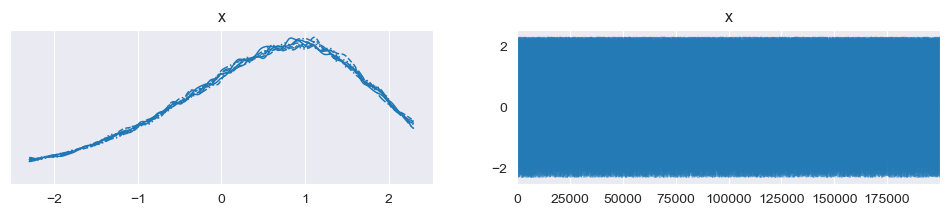

In [26]:
az.plot_trace(idata)

<Axes: title={'center': 'x\n0'}>

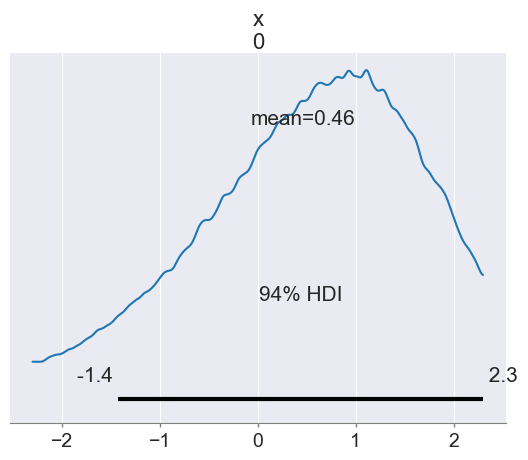

In [27]:
az.plot_posterior(idata)

In [3]:
import numpy as np
import pytensor.tensor as pt
from pytensor.graph.op import Op, Apply
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt

# Define interpolate function
def interpolate(x0, y0, x):
    x = np.array(x)
    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d
    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

# Load data and ensure it's a NumPy array
data = pd.read_csv('grids_example_1.csv', header=None).values
param_min = data[0, :].min()
param_max = data[0, :].max()

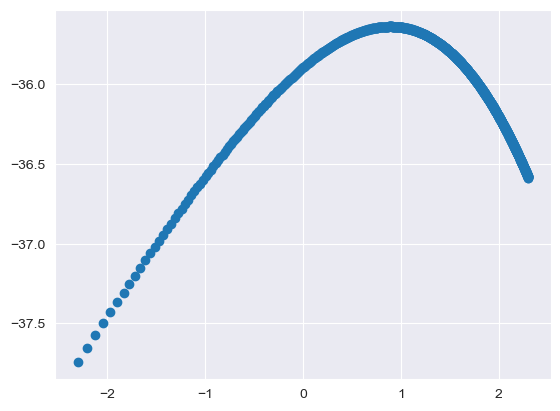

In [21]:
# plot the data
plt.plot(data[0, :], data[1, :], 'o')

plt.show()